1. Setup and Dataset Paths (Colab + Drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os

zip_path = "/content/drive/MyDrive/Chest X-Ray Images (Pneumonia).zip"
extract_path = "/content/data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files in /content/data:", os.listdir("/content/data"))

DATA_DIR = "/content/data/Chest X-Ray Images (Pneumonia)/chest_xray"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR   = DATA_DIR + "/val"
TEST_DIR  = DATA_DIR + "/test"

print("Subfolders:", os.listdir(DATA_DIR))



Mounted at /content/drive
Files in /content/data: ['Chest X-Ray Images (Pneumonia)']
Subfolders: ['__MACOSX', 'val', 'test', 'chest_xray', 'train']


2. Load Datasets with image_dataset_from_directory

In [2]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


Prefetch for Performance

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


3. Data Augmentation and Preprocessing

In [4]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.efficientnet.preprocess_input


4.Build the EfficientNetB0 Model

In [5]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = False  # fine‑tune later if you want

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation='softmax', name="classifier")(x)

model = tf.keras.Model(inputs, outputs, name="efficientnetb0_pneumonia")
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0_pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

5. Compile, Early Stopping, and Train

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stop]
)


Epoch 1/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - accuracy: 0.8570 - loss: 0.3248 - val_accuracy: 0.8750 - val_loss: 0.2321
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - accuracy: 0.9312 - loss: 0.1682 - val_accuracy: 0.9375 - val_loss: 0.1637
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - accuracy: 0.9424 - loss: 0.1499 - val_accuracy: 1.0000 - val_loss: 0.1387
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9462 - loss: 0.1367 - val_accuracy: 1.0000 - val_loss: 0.1282
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9469 - loss: 0.1339 - val_accuracy: 0.9375 - val_loss: 0.1231
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9527 - loss: 0.1223 - val_accuracy: 0.9375 - val_loss: 0.1267
Epoch 7/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.9454 - loss: 0.1291 - val_accuracy: 1.0000 - val_loss: 0.1086
Epoch 8/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 76s 109ms/step - accuracy: 0.9541 - loss: 0

6.Plot Training Accuracy & Loss

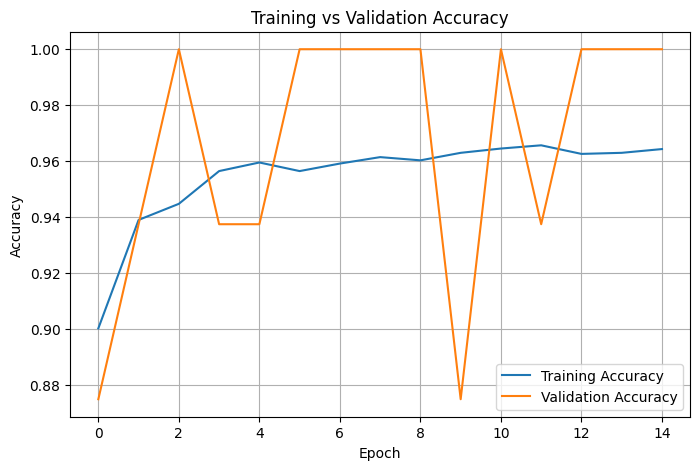

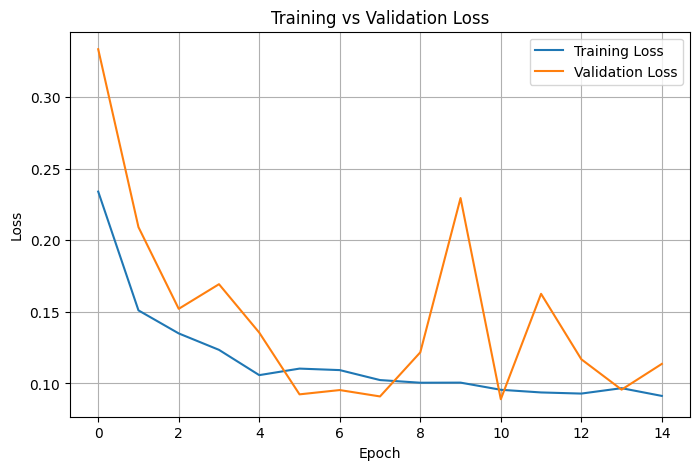

''

In [ ]:
import matplotlib.pyplot as plt

# ---- ACCURACY ----
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---- LOSS ----
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
""

7. Evaluate on Test Set and Confusion Matrix

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8164 - loss: 0.4287
Test Accuracy: 0.88, Test Loss: 0.29
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
              precision    recall  f1-score   support

      NORMAL       0.91      0.75      0.82       234
   PNEUMONIA       0.86      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



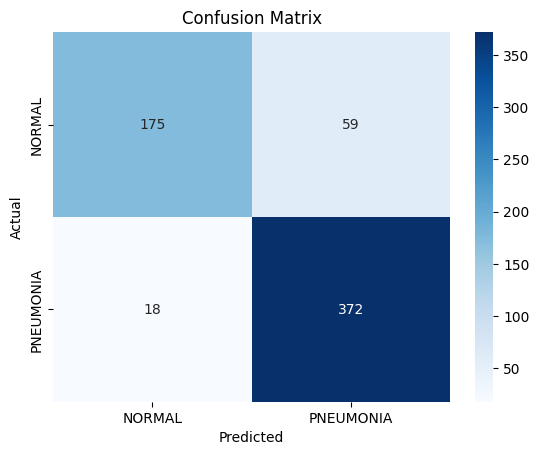

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

# Get predictions
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


In [18]:

# Get the EfficientNet model
efficientnet_model = model.get_layer('efficientnetb0')

# Print layers inside EfficientNet
print("Layers inside EfficientNetB0:")
conv_layers = []
for i, layer in enumerate(efficientnet_model.layers):
    if 'conv' in layer.name or isinstance(layer, tf.keras.layers.Conv2D):
        conv_layers.append(layer.name)
        print(f"  {i}: {layer.name} - {layer.__class__.__name__}")

print(f"\nFound {len(conv_layers)} convolutional layers in EfficientNet")
print(f"Last conv layer: {conv_layers[-1] if conv_layers else 'None'}")

Layers inside EfficientNetB0:
  4: stem_conv_pad - ZeroPadding2D
  5: stem_conv - Conv2D
  8: block1a_dwconv - DepthwiseConv2D
  13: block1a_se_reduce - Conv2D
  14: block1a_se_expand - Conv2D
  16: block1a_project_conv - Conv2D
  18: block2a_expand_conv - Conv2D
  21: block2a_dwconv_pad - ZeroPadding2D
  22: block2a_dwconv - DepthwiseConv2D
  27: block2a_se_reduce - Conv2D
  28: block2a_se_expand - Conv2D
  30: block2a_project_conv - Conv2D
  32: block2b_expand_conv - Conv2D
  35: block2b_dwconv - DepthwiseConv2D
  40: block2b_se_reduce - Conv2D
  41: block2b_se_expand - Conv2D
  43: block2b_project_conv - Conv2D
  47: block3a_expand_conv - Conv2D
  50: block3a_dwconv_pad - ZeroPadding2D
  51: block3a_dwconv - DepthwiseConv2D
  56: block3a_se_reduce - Conv2D
  57: block3a_se_expand - Conv2D
  59: block3a_project_conv - Conv2D
  61: block3b_expand_conv - Conv2D
  64: block3b_dwconv - DepthwiseConv2D
  69: block3b_se_reduce - Conv2D
  70: block3b_se_expand - Conv2D
  72: block3b_project

Sample Predictions (Correct vs Incorrect)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


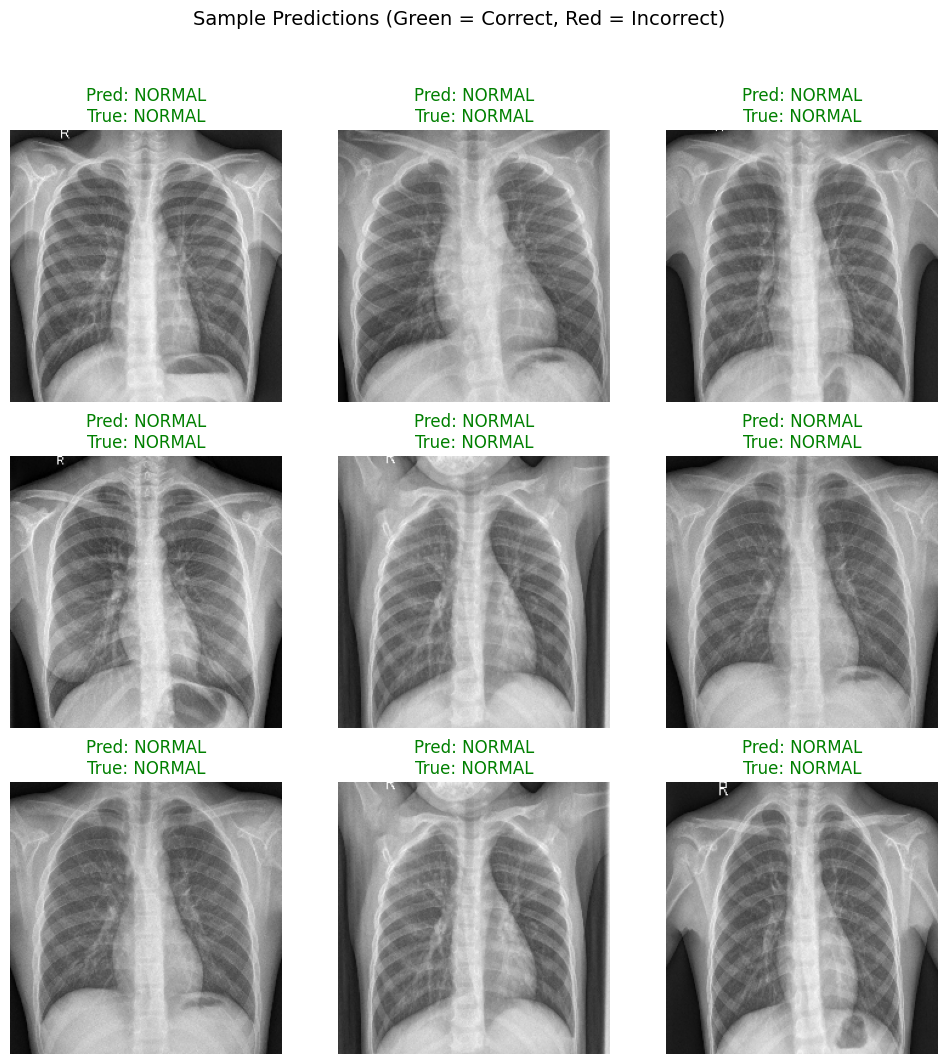

In [28]:
import matplotlib.pyplot as plt
import random

# Take a batch from test set
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

# Plot 9 random images
plt.figure(figsize=(12,12))

for i in range(9):
    idx = random.randint(0, len(images) - 1)
    plt.subplot(3, 3, i+1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    color = "green" if preds[idx] == labels[idx] else "red"
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}", color=color)
    plt.axis("off")

plt.suptitle("Sample Predictions (Green = Correct, Red = Incorrect)", fontsize=14)
plt.show()


ROC Curve + AUC Score

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step


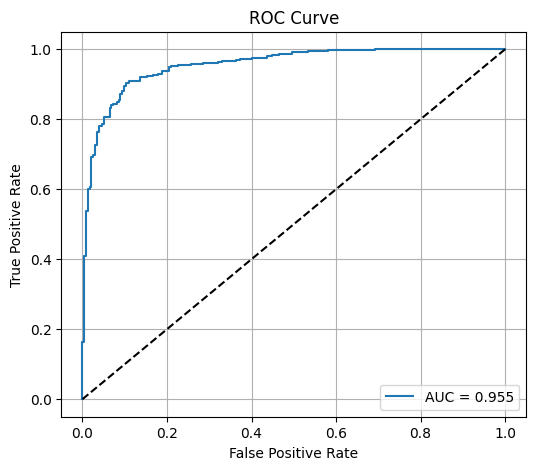

AUC Score: 0.9547446855139163


In [29]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Convert labels to one-hot
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=2)

# Calculate predicted probabilities
y_pred_prob = model.predict(test_ds)

# Use predicted probabilities for ROC
y_score = y_pred_prob

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin[:, 1], y_score[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc)

Save Final Model

In [30]:
model.save("pneumonia_efficientnet_final.keras")
